<a href="https://colab.research.google.com/github/sailorcosmos101/3D-PINN-for-GW/blob/main/Case4_darcys_flow_2d_homo_pressure_based_250704.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import required Python libraries

In [45]:
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap, jacfwd, jacrev
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## 2. Define Domain and Boundary Conditions, and Generate Collocation Points

In [46]:
xmin_org, xmax_org = 0, 1e+4
ymin_org, ymax_org = 0 , 1e+4
delta_x = xmax_org - xmin_org
delta_y = ymax_org - ymin_org

xmin = xmin_org/delta_x
xmax = xmax_org/delta_x
ymin = ymin_org/delta_y
ymax = ymax_org/delta_y

# Define the boundary conditions
h1 = 60            # at x = 0 for all y_b1, Dirichlet boundary at the left (m)
h2 = 0             # at x = 1 for all y, Dirichlet boundary at the right (m)
dh_dy1 = 0           # at y = 0 for all x, Neumann boundary at the bottom (m)
dh_dy2 = 0           # at y = 1 for all x, Neumann boundary at the top (m)

# define the number of points on each boundary and
N_b = 100          # Number of boundary condition points on each side.
N_r = 5000        # Number of collocation points within the domain

In [47]:
def generate_BCs_and_colloc(N_b, N_r, ymin, ymax, xmin, xmax, h1, h2, dh_dy1, dh_dy2,
                                N_riv=100, x_riv_fixed=0.5, y_riv_start=0.0, y_riv_end=1.0, h_riv=40.0, C_riv=1e-3, z_b=25.0):
    """
    Generates boundary conditions, collocation points, and RIV boundary points.

    Returns:
    - boundary condition arrays, collocation points, and RIV boundary arrays including bottom elevation
    """
    bk1, bk2, bk3, bk4, r1k, r2k, riv_k = jax.random.split(jax.random.PRNGKey(0), 7)

    # Dirichlet and Neumann BCs (same as before)
    y_b1 = jax.random.uniform(bk1, minval=ymin, maxval=ymax, shape=(N_b, 1))
    x_b1 = jnp.zeros_like(y_b1)
    bc_1 = jnp.ones_like(y_b1) * h1
    BC_1 = jnp.concatenate([x_b1, y_b1, bc_1], axis=1)

    y_b2 = jax.random.uniform(bk2, minval=ymin, maxval=ymax, shape=(N_b, 1))
    x_b2 = jnp.ones_like(y_b2) * xmax
    bc_2 = jnp.ones_like(y_b2) * h2
    BC_2 = jnp.concatenate([x_b2, y_b2, bc_2], axis=1)

    x_b3 = jax.random.uniform(bk3, minval=xmin, maxval=xmax, shape=(N_b, 1))
    y_b3 = jnp.zeros_like(x_b3)
    bc_3 = jnp.ones_like(x_b3) * dh_dy1
    BC_3 = jnp.concatenate([x_b3, y_b3, bc_3], axis=1)

    x_b4 = jax.random.uniform(bk4, minval=xmin, maxval=xmax, shape=(N_b, 1))
    y_b4 = jnp.ones_like(x_b4) * ymax
    bc_4 = jnp.ones_like(x_b4) * dh_dy2
    BC_4 = jnp.concatenate([x_b4, y_b4, bc_4], axis=1)

    conds = [BC_1, BC_2, BC_3, BC_4]

    # Collocation points
    y_c = jax.random.uniform(r1k, minval=ymin, maxval=ymax, shape=(N_r, 1))
    x_c = jax.random.uniform(r2k, minval=xmin, maxval=xmax, shape=(N_r, 1))
    colloc = jnp.concatenate([x_c, y_c], axis=1)

    # RIV boundary points
    y_riv = jax.random.uniform(riv_k, shape=(N_riv, 1), minval=y_riv_start, maxval=y_riv_end)
    x_riv = jnp.ones_like(y_riv) * x_riv_fixed
    h_riv_elev_array = jnp.ones_like(y_riv) * h_riv
    C_riv_array = jnp.ones_like(y_riv) * C_riv
    bottom_elev_array = jnp.ones_like(y_riv) * z_b

    return (x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4,
            x_c, y_c, conds, colloc,
            x_riv, y_riv, h_riv_elev_array, C_riv_array, bottom_elev_array)

(x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4,
            x_c, y_c, conds, colloc,
            x_riv, y_riv, h_riv_elev_array, C_riv_array, bottom_elev_array)=generate_BCs_and_colloc(N_b, N_r, ymin, ymax, xmin, xmax, h1, h2, dh_dy1, dh_dy2,
                                N_riv=100, x_riv_fixed=0.5, y_riv_start=0.0, y_riv_end=1.0, h_riv=40.0, C_riv=1e-1, z_b=25.0)

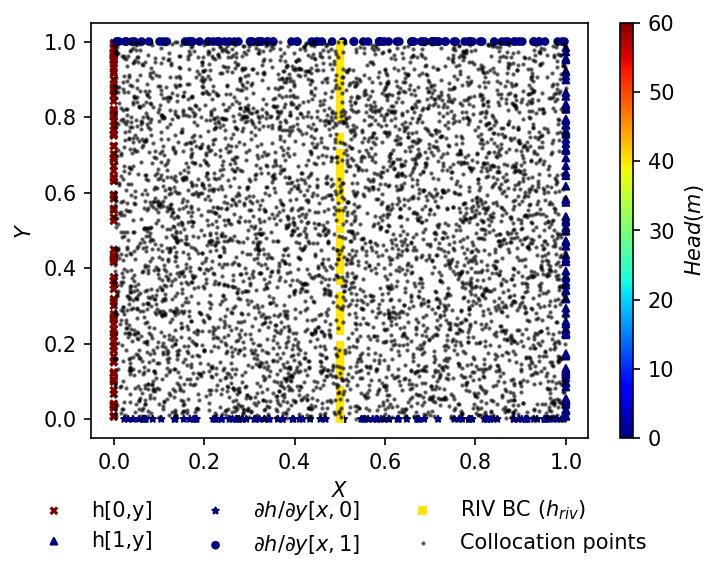

In [48]:
def plot_boundary_conditions(x_b1, y_b1, bc_1, x_b2, y_b2, bc_2,
                            x_b3, y_b3, bc_3, x_b4, y_b4, bc_4,
                            x_c, y_c,
                            x_riv, y_riv, h_riv_elev_array):
    plt.figure(figsize=(5, 4), dpi=150)

    # Combine all values for color scaling
    all_bc_values = np.concatenate([bc_1, bc_2, bc_3, bc_4, h_riv_elev_array])
    vmin, vmax = all_bc_values.min(), all_bc_values.max()

    # Plot Dirichlet boundaries
    s = 10
    scatter1 = plt.scatter(x_b1, y_b1, c=bc_1, marker='x', vmin=vmin, vmax=vmax, label='h[0,y]', cmap=cm.jet, s=s)
    plt.scatter(x_b2, y_b2, c=bc_2, marker='^', vmin=vmin, vmax=vmax, label='h[1,y]', cmap=cm.jet, s=s)

    # Plot Neumann boundaries
    plt.scatter(x_b3, y_b3, c=bc_3, marker='*', vmin=vmin, vmax=vmax, label='$\\partial h/\\partial y[x,0]$', cmap=cm.jet, s=s)
    plt.scatter(x_b4, y_b4, c=bc_4, marker='o', vmin=vmin, vmax=vmax, label='$\\partial h/\\partial y[x,1]$', cmap=cm.jet, s=s)

    # Plot RIV boundary (head-dependent flux)
    plt.scatter(x_riv, y_riv, c=h_riv_elev_array, marker='s', vmin=vmin, vmax=vmax, label='RIV BC ($h_{riv}$)', cmap=cm.jet, s=s)

    # Plot collocation points
    s = 5
    plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.5, label='Collocation points', s=s)

    # Labels and colorbar
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    cbar = plt.colorbar(scatter1, aspect=30)
    cbar.set_label('$Head (m)$')

    # Legend below the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
    plt.tight_layout()

plot_boundary_conditions(x_b1, y_b1, bc_1, x_b2, y_b2, bc_2,
                            x_b3, y_b3, bc_3, x_b4, y_b4, bc_4,
                            x_c, y_c,
                            x_riv, y_riv, h_riv_elev_array)

## 3. Define PDE Residual

In [49]:
def hydraulic_conductivity(x, y):
  T_x = jnp.ones_like(x)*15/10
  T_y = jnp.ones_like(y)*15/10
  return T_x, T_y

In [50]:
def pde_residual_2d_darcy(x,y,h):
    """
    Compute the PDE residual for the 2D Laplace equation.

    Inputs:
    x, y: Coordinates of collocation points (N x 1).
    h: Lambda function representing the neural network solution h(x, y).

    Output:
    Residual of the PDE at the collocation points (N x 1).
    """
    T_x, T_y = hydraulic_conductivity(x, y)

    h_x = lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),0)(x,y)
    h_xx = lambda x,y:jax.grad(lambda x,y:jnp.sum(h_x(x,y)),0)(x,y)

    h_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),1)(x,y)
    h_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(h_y(x,y)),1)(x,y)

    return T_x*h_xx(x,y) + T_y*h_yy(x,y)

## 4. Define Neural Network Architecture

In [51]:
# Define Neural Network Architecture
def neural_net(params, x, y):
    """
    Forward pass of a neural network to predict h(x, y).

    Inputs:
    params: Neural network parameters (list of weights and biases).
    x, y: Input coordinates (N x 1).

    Output:
    Predicted h(x, y) values (N x 1).
    """
    X = jnp.concatenate([x, y],axis=1)
    *hidden,last = params
    for layer in hidden :
        X = jax.nn.tanh(X@layer['W']+layer['B'])
    return X@last['W'] + last['B']


# Function to initialize parameters of the neural network (weights and biases)
def init_params(layers):
    """
    Initialize parameters (weights and biases) for a neural network with specified layers.

    Args:
        layers: List of integers representing the number of nodes in each layer.
                For example, [2, 20, 20, 1] creates a network with input layer (2 nodes),
                two hidden layers (20 nodes each), and an output layer (1 node).

    Returns:
        params: List of dictionaries containing 'W' (weights) and 'B' (biases) for each layer.
    """
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)  # Generate random keys for each layer
    params = list()  # Initialize a list to store layer parameters

    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):  # Loop through layer dimensions
        lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in))  # Xavier initialization bounds
        W = lb + (ub - lb) * jax.random.uniform(key, shape=(n_in, n_out))  # Initialize weights
        B = jax.random.uniform(key, shape=(n_out,))  # Initialize biases
        params.append({'W': W, 'B': B})  # Append layer parameters (weights and biases) to the list

    return params  # Return the initialized parameters

## 5. Define Loss Function

In [52]:
@jax.jit
def loss_fun(params, colloc, conds, x_riv, y_riv, h_riv_elev_array, C_riv_array, bottom_elev_array):
    """
    Calculate the total loss for the PINN, including PDE residual, Dirichlet, Neumann, and physically consistent RIV boundary conditions.
    """
    x_c, y_c = colloc[:, [0]], colloc[:, [1]]
    h_nn = lambda x, y: neural_net(params, x, y)

    # PDE residual loss
    # pde_loss = jnp.mean((pde_residual_2d_darcy(x_c, y_c, h_nn)+1e-5/(1e-4)**2)**2)
    pde_loss = jnp.mean((pde_residual_2d_darcy(x_c, y_c, h_nn))**2)

    # Dirichlet BC loss
    dbc_loss = 0.0
    for cond in conds[0:2]:
        x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]
        dbc_loss += jnp.mean((h_nn(x_b, y_b) - u_b)**2)

    # Neumann BC loss
    nbc_loss = 0.0
    h_nn_y = lambda x, y: jax.grad(lambda x, y: jnp.sum(h_nn(x, y)), 1)(x, y)
    for cond in conds[2:4]:
        x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]
        nbc_loss += jnp.mean((h_nn_y(x_b, y_b) - u_b)**2)

    # RIV boundary condition
    h_riv = h_nn(x_riv, y_riv)
    sigmoid = lambda x: 1 / (1 + jnp.exp(-x))
    riv_flux = C_riv_array*((h_riv_elev_array-h_riv)*sigmoid(h_riv-bottom_elev_array)+(h_riv_elev_array-bottom_elev_array)*sigmoid(h_riv-bottom_elev_array))

    riv_loss = jnp.mean((pde_residual_2d_darcy(x_riv, y_riv, h_nn)+(riv_flux)/(1e-4)**2)**2)

    loss = 1e-2 * pde_loss + 100*dbc_loss + nbc_loss + 1e-4 * riv_loss
    return loss

## 6. Define Hyperparameters and Training Loop
This cell contains the training loop for the Physics-Informed Neural Network (PINN). It includes functions and code to update the network parameters, compute the loss, track training progress, and identify the best-performing model during the training process.

In [53]:
#%% PINN prediction and plotting results
nx = 31
x = np.linspace(xmin, xmax, nx)
dx = x[1] - x[0]
ny = 31
y = np.linspace(ymin, ymax, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

In [68]:
# Define hyperparameters for the neural network and training
hidden_nodes = 20      # Number of nodes in each hidden layer
hidden_layers = 3      # Number of hidden layers in the neural network
lr = 1e-3              # Learning rate for the optimizer
epochs = 30000         # Number of epochs for training

# Construct the MLP (Multilayer Perceptron) using the specified architecture
params = init_params([2] + [hidden_nodes] * hidden_layers + [1])

# Define the optimizer (Adam optimizer with the specified learning rate)
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

# Parameters update function with RIV support
@jax.jit
def update(opt_state, params, colloc, conds, x_riv, y_riv, h_riv_elev_array, C_riv_array, bottom_elev_array):
    grads = jax.grad(loss_fun, 0)(params, colloc, conds, x_riv, y_riv, h_riv_elev_array, C_riv_array, bottom_elev_array)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

#%% PINN training loop
print('PINN training started...')

best_params = params
best_loss = float('inf')
best_epoch = 0
all_losses = []
all_epochs = []

for epoch in range(epochs+1):
    opt_state, params = update(opt_state, params, colloc, conds, x_riv, y_riv, h_riv_elev_array, C_riv_array, bottom_elev_array)
    current_loss = loss_fun(params, colloc, conds, x_riv, y_riv, h_riv_elev_array, C_riv_array, bottom_elev_array)

    all_losses.append(current_loss)
    all_epochs.append(epoch)

    if current_loss < best_loss:
        best_loss = current_loss
        best_params = params
        best_epoch = epoch

    if epoch % 100 == 0:
        print(f'Epoch={epoch}\tloss={current_loss:.3e}')
        pinn_h = (neural_net(best_params, X.flatten().reshape(-1,1), Y.flatten().reshape(-1,1))).reshape(nx,ny)

print('PINN training done!')
print(f'Best Epoch = {best_epoch}\tBest Loss = {best_loss:.3e}')


PINN training started...
Epoch=0	loss=3.513e+05
Epoch=100	loss=2.912e+05
Epoch=200	loss=2.560e+05
Epoch=300	loss=2.203e+05
Epoch=400	loss=1.923e+05
Epoch=500	loss=1.673e+05
Epoch=600	loss=1.452e+05
Epoch=700	loss=1.256e+05
Epoch=800	loss=1.082e+05
Epoch=900	loss=9.282e+04
Epoch=1000	loss=7.924e+04
Epoch=1100	loss=6.732e+04
Epoch=1200	loss=5.689e+04
Epoch=1300	loss=4.781e+04
Epoch=1400	loss=3.995e+04
Epoch=1500	loss=3.318e+04
Epoch=1600	loss=2.741e+04
Epoch=1700	loss=2.252e+04
Epoch=1800	loss=1.841e+04
Epoch=1900	loss=1.500e+04
Epoch=2000	loss=1.218e+04
Epoch=2100	loss=9.869e+03
Epoch=2200	loss=7.998e+03
Epoch=2300	loss=6.491e+03
Epoch=2400	loss=5.278e+03
Epoch=2500	loss=4.305e+03
Epoch=2600	loss=3.532e+03
Epoch=2700	loss=2.898e+03
Epoch=2800	loss=2.275e+03
Epoch=2900	loss=1.717e+03
Epoch=3000	loss=1.308e+03
Epoch=3100	loss=1.023e+03
Epoch=3200	loss=8.240e+02
Epoch=3300	loss=6.862e+02
Epoch=3400	loss=5.923e+02
Epoch=3500	loss=5.303e+02
Epoch=3600	loss=4.900e+02
Epoch=3700	loss=4.641e+02

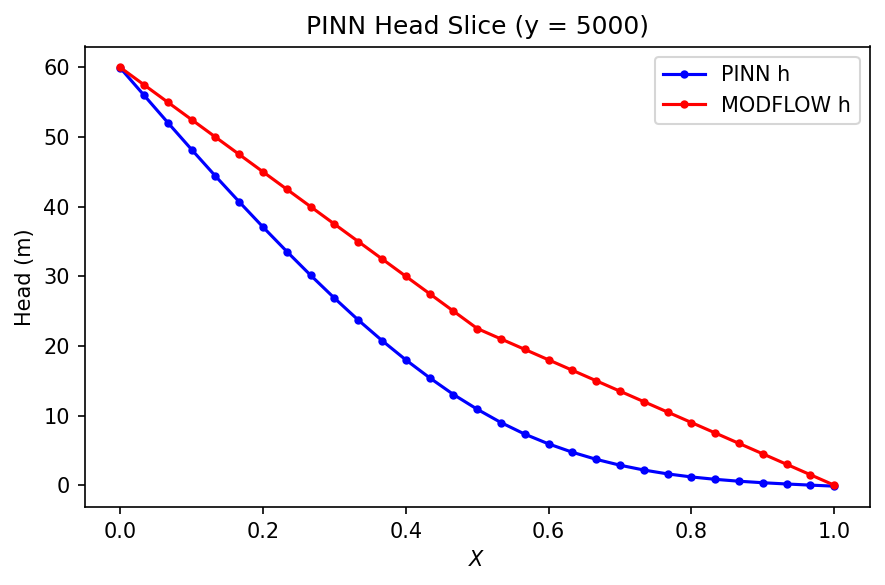

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def plot_head_slice_with_extra(X_phys, Y_phys, h, y0_phys, title, xlabel, ylabel, extra_h_vals):
    """
    - X_phys, Y_phys: 2D meshgrid(physical coordinates)
    - h: 2D array of head 값 (same shape as X_phys/Y_phys)
    - y0_phys: y = 5000 같은 물리 단위 상의 슬라이스 위치
    - extra_h_vals: y0_phys 위치에서 각 x 위치에 대응하는 추가로 찍을 Head 값 리스트 (1D, 길이는 x_line 길이와 일치)
    """
    # 1) y0_phys에 가장 가까운 행 인덱스 찾기
    y_column = Y_phys[:, 0]
    idx = np.argmin(np.abs(y_column - y0_phys))

    # 2) x_line(해당 행의 x 좌표), h_line(기존 PINN 예측 head)
    x_line = X_phys[idx, :]      # [N,] shape
    h_line = h[idx, :]           # [N,] shape

    # 3) extra_h_vals가 x_line 길이와 동일한지 확인
    extra_h_vals = np.array(extra_h_vals, dtype=float)
    if extra_h_vals.shape[0] != x_line.shape[0]:
        raise ValueError(f"extra_h_vals 길이({extra_h_vals.shape[0]})가 x_line 길이({x_line.shape[0]})와 다릅니다.")

    # 4) 플롯 그리기
    plt.figure(figsize=(6, 4), dpi=150)

    # 4-1) 기존 PINN 예측 head (파란색 선 + 원형 마커)
    plt.plot(x_line, h_line, '-o', color='b', markersize=3, label='PINN h')

    # 4-2) 새로운 추가 Head 값(빨간색 선 + 원형 마커)
    plt.plot(x_line, extra_h_vals, '-o', color='r', markersize=3, label='MODFLOW h')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (y = {y0_phys})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------
# 사용 예시
# ---------------------------------------------------

# (1) 이미 X_phys, Y_phys, pinn_h, delta_x, delta_y, xmin_org, ymin_org이 정의되었다고 가정
#     예: X_phys = X * delta_x + xmin_org
#          Y_phys = Y * delta_y + ymin_org

y0_phys = 5000
title_slice = "PINN Head Slice"
xlabel = "$X$"
ylabel = "Head (m)"

# (2) 마지막으로 주신 31개의 추가 Head 값 리스트
extra_h_vals = [
    60,
    57.50122,
    55.00114,
    52.50129,
    50.00132,
    47.50121,
    45.00102,
    42.50084,
    40.00074,
    37.50071,
    35.0007,
    32.50066,
    30.00056,
    27.50044,
    25.00036,
    22.50039,
    20.99994,
    19.49964,
    17.99945,
    16.49935,
    14.99935,
    13.49947,
    11.99967,
    10.49988,
    9.00004,
    7.50012,
    6.000156,
    4.500185,
    3.000191,
    1.500133,
    0
]

# (3) 함수 호출
plot_head_slice_with_extra(
    X, Y, pinn_h, y0_phys,
    title_slice, xlabel, ylabel,
    extra_h_vals
)


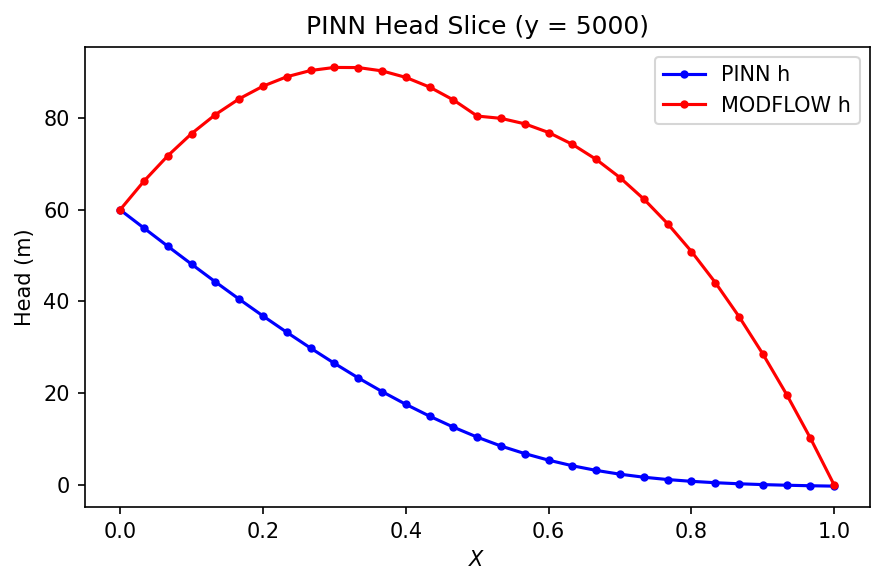

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_head_slice_with_extra(X_phys, Y_phys, h, y0_phys, title, xlabel, ylabel, extra_h_vals):
    """
    - X_phys, Y_phys: 2D meshgrid(physical coordinates)
    - h: 2D array of head 값 (same shape as X_phys/Y_phys)
    - y0_phys: y = 5000 같은 물리 단위 상의 슬라이스 위치
    - extra_h_vals: y0_phys 위치에서 각 x 위치에 대응하는 추가로 찍을 Head 값 리스트 (1D, 길이는 x_line 길이와 일치)
    """
    # 1) y0_phys에 가장 가까운 행 인덱스 찾기
    y_column = Y_phys[:, 0]
    idx = np.argmin(np.abs(y_column - y0_phys))

    # 2) x_line(해당 행의 x 좌표), h_line(기존 PINN 예측 head)
    x_line = X_phys[idx, :]      # [N,] shape
    h_line = h[idx, :]           # [N,] shape

    # 3) extra_h_vals가 x_line 길이와 동일한지 확인
    extra_h_vals = np.array(extra_h_vals, dtype=float)
    if extra_h_vals.shape[0] != x_line.shape[0]:
        raise ValueError(f"extra_h_vals 길이({extra_h_vals.shape[0]})가 x_line 길이({x_line.shape[0]})와 다릅니다.")

    # 4) 플롯 그리기
    plt.figure(figsize=(6, 4), dpi=150)

    # 4-1) 기존 PINN 예측 head (파란색 선 + 원형 마커)
    plt.plot(x_line, h_line, '-o', color='b', markersize=3, label='PINN h')

    # 4-2) 새로운 추가 Head 값(빨간색 선 + 원형 마커)
    plt.plot(x_line, extra_h_vals, '-o', color='r', markersize=3, label='MODFLOW h')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (y = {y0_phys})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------
# 사용 예시
# ---------------------------------------------------

# (1) 이미 X_phys, Y_phys, pinn_h, delta_x, delta_y, xmin_org, ymin_org이 정의되었다고 가정
#     예: X_phys = X * delta_x + xmin_org
#          Y_phys = Y * delta_y + ymin_org

y0_phys = 5000
title_slice = "PINN Head Slice"
xlabel = "$X$"
ylabel = "Head (m)"

# (2) 새로 주신 31개의 추가 Head 값 리스트
extra_h_vals = [
    60,
    66.21268,
    71.73223,
    76.55808,
    80.69036,
    84.12904,
    86.87406,
    88.92542,
    90.28307,
    90.94701,
    90.91724,
    90.19377,
    88.77663,
    86.66579,
    83.86122,
    80.36288,
    79.86156,
    78.66646,
    76.77757,
    74.19485,
    70.91834,
    66.94804,
    62.284,
    56.92628,
    50.87495,
    44.13007,
    36.69165,
    28.55957,
    19.73361,
    10.21357,
    0
]

# (3) 함수 호출
plot_head_slice_with_extra(
    X, Y, pinn_h, y0_phys,
    title_slice, xlabel, ylabel,
    extra_h_vals
)


## 7. Plot pinn loss during training

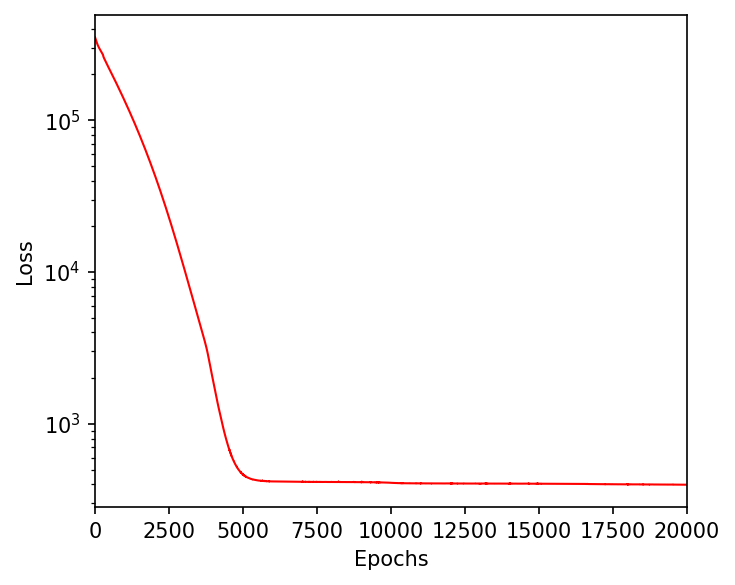

In [57]:
#function for plotting for PINN losses during training
def plot_pinn_training(all_losses, all_epochs):
    plt.figure(figsize = (5, 4), dpi = 150)
    plt.semilogy(all_epochs, all_losses, '-r', markersize = 4, linewidth = 1.0)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.legend(prop={"size": fontsize_legend}, loc="best")
    plt.xlim(min(all_epochs), max(all_epochs))
    plt.tight_layout()

plot_pinn_training(all_losses, all_epochs)

## 8. PINN prediction and plotting results

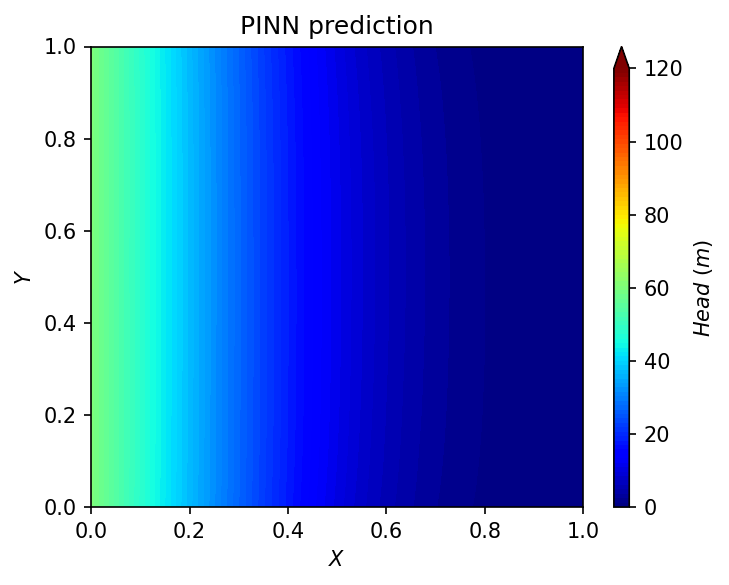

In [58]:
def plot_2d_pressure_distribution(X, Y, h, title, cbar_label):
    plt.figure(figsize=(5, 4), dpi=150)
    cmap = 'jet'

    # 색상 범위를 0~120으로 고정
    levels = np.linspace(0, 120, 100)

    # 음수 값을 0으로 클리핑 (시각적으로만 처리)
    h_clipped = np.clip(h, 0, 120)

    contour = plt.contourf(
        X, Y, h_clipped,
        levels=levels,
        cmap=cmap,
        extend='max'  # 120 넘는 값만 따로 색상 처리
    )

    plt.xlabel('$X$')
    plt.ylabel('$Y$')

    cbar = plt.colorbar(contour, aspect=30)
    cbar.set_label(cbar_label)

    # 컬러바 눈금을 0 ~ 120 고정
    cbar.set_ticks(np.arange(0, 121, 20))

    plt.xlim(np.min(X), np.max(X))
    plt.ylim(np.min(Y), np.max(Y))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 사용 예시
title = "PINN prediction"
cbar_label = "$Head\\ (m)$"
plot_2d_pressure_distribution(X, Y, pinn_h, title, cbar_label)

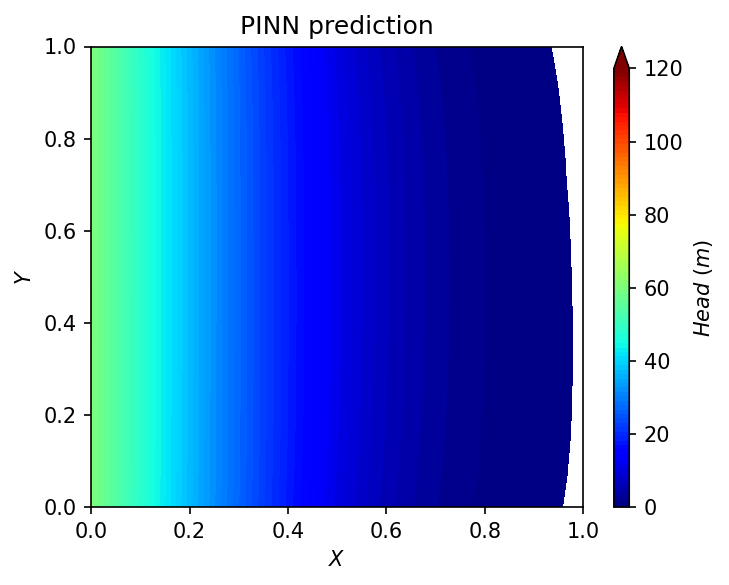

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d_pressure_distribution(X, Y, h, title, cbar_label):
    plt.figure(figsize=(5, 4), dpi=150)
    cmap = 'jet'

    # levels를 0부터 120까지 균등하게 100개로 나눔
    levels = np.linspace(0, 120, 100)

    contour = plt.contourf(
        X, Y, h,
        levels=levels,  # <-- 이 줄이 중요
        cmap=cmap,
        extend='max'    # 데이터가 120보다 크면 넘는 부분을 최댓값 색으로 표시
    )

    plt.xlabel('$X$')
    plt.ylabel('$Y$')

    cbar = plt.colorbar(contour, aspect=30)
    cbar.set_label(cbar_label)

    # 컬러바 눈금을 직접 0, 20, 40, ... 120 으로 지정
    cbar.set_ticks(np.arange(0, 121, 20))

    plt.xlim(np.min(X), np.max(X))
    plt.ylim(np.min(Y), np.max(Y))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 사용 예시
title = "PINN prediction"
cbar_label = "$Head\\ (m)$"
plot_2d_pressure_distribution(X, Y, pinn_h, title, cbar_label)


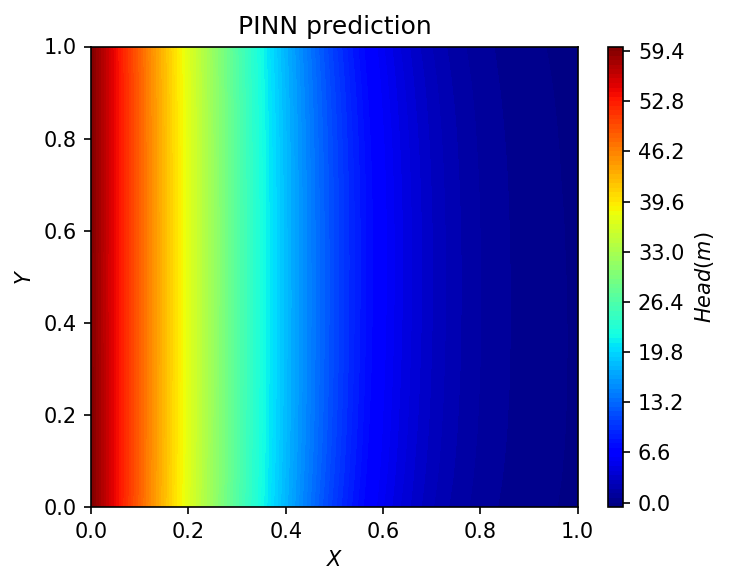

In [60]:
def plot_2d_pressure_distribution(X, Y, h, title, cbar_lebel):
    plt.figure(figsize = (5, 4), dpi = 150)
    cmap = 'jet'
    contour = plt.contourf(X, Y, h, levels=100, cmap=cmap)
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    # Colorbar settings
    vmin = np.min(h)
    vmax = np.max(h)
    #cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin = vmin, vmax = vmax), cmap=cm.jet), aspect=30)
    cbar = plt.colorbar(contour, aspect=30)


    cbar.set_label(f'{cbar_lebel}')
    plt.xlim(np.min(X), np.max(X))
    plt.ylim(np.min(Y), np.max(Y))
    plt.title(title)
    plt.tight_layout()

title = "PINN prediction"
cbar_lebel = "$Head (m)$"
plot_2d_pressure_distribution(X, Y, pinn_h, title, cbar_lebel)

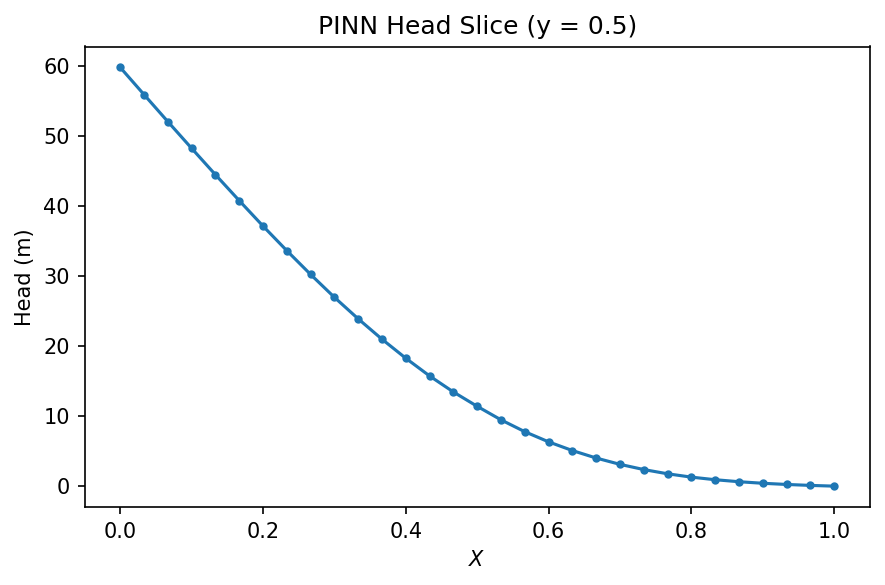

In [61]:
def plot_head_slice_at_y(X, Y, h, y0, title, xlabel, ylabel):
    # y=y0에 가까운 인덱스 찾기
    y_column = Y[:, 0]
    idx = np.argmin(np.abs(y_column - y0))

    # 해당 행(row)의 x값, h값 추출
    x_line = X[idx, :]
    h_line = h[idx, :]

    # 새로운 Figure 생성
    plt.figure(figsize=(6, 4), dpi=150)
    plt.plot(x_line, h_line, '-o', markersize=3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (y = {y0})")
    plt.tight_layout()
    plt.show()  # 이 줄이 있어야 선 그래프가 별도 플롯으로 출력됩니다.

y0 = 0.5
title_slice = "PINN Head Slice"
xlabel = "$X$"
ylabel = "Head (m)"
plot_head_slice_at_y(X, Y, pinn_h, y0, title_slice, xlabel, ylabel)

## 9. Solution verifications

In [62]:
#%% Analytical solution
L = xmax
analytical_h = h1 + (h2 - h1) * X / L
#print(analytical_P)

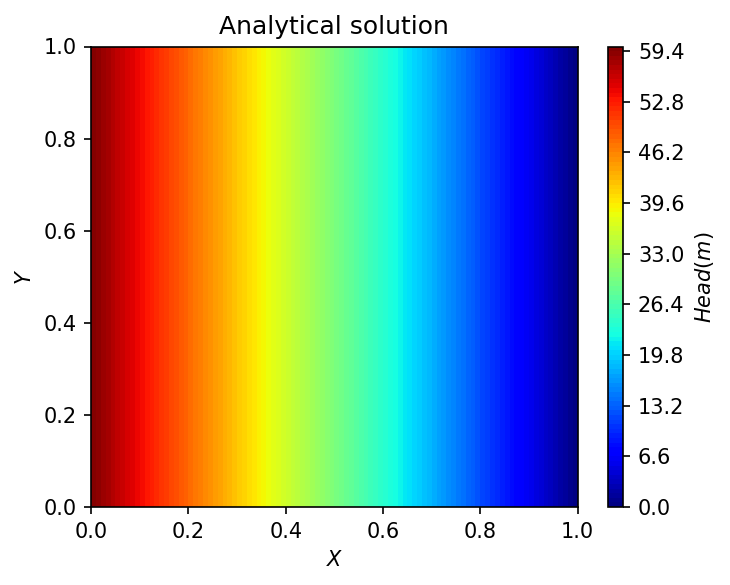

In [63]:
title = "Analytical solution"
cbar_lebel = "$Head (m)$"
plot_2d_pressure_distribution(X, Y, analytical_h, title, cbar_lebel)

## 10. Error analysis between the analytical solution and PINN prediction

R^2 Score: 0.8951
Root Mean Squared Error (RMSE): 6.1198


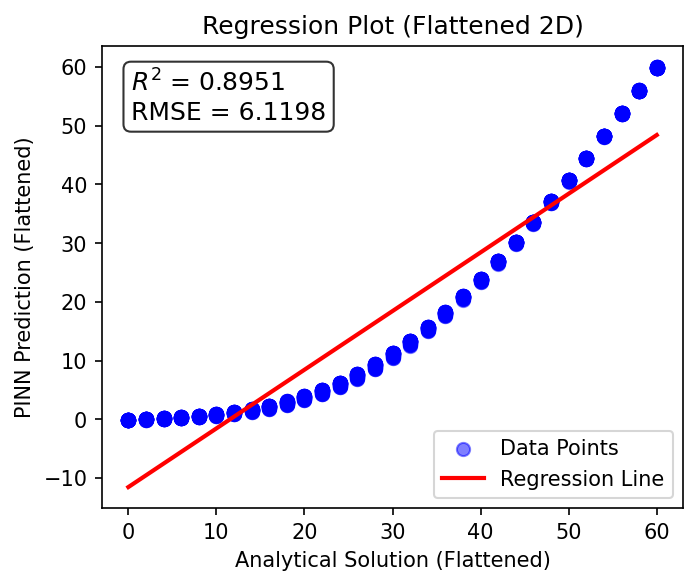

In [64]:
# Flatten the 2D arrays into 1D
analytical_hr = analytical_h.flatten().reshape(-1, 1)  # Flatten to 1D and reshape to 2D (n_samples, n_features)
pinn_hr = pinn_h.flatten()                       # Flatten to 1D (n_samples,)

# Perform regression
reg = LinearRegression()
reg.fit(analytical_hr, pinn_hr)  # Fit the model

# Predict using the regression model
y_pred = reg.predict(analytical_hr)

# Calculate R^2 score
r2 = r2_score(pinn_hr, y_pred)

# Calculate RMSE
mse = mean_squared_error(pinn_hr, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Erro

# Print results
print(f"R^2 Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

#%% Plotting Regression
plt.figure(figsize=(5, 4), dpi = 150)
plt.scatter(analytical_hr, pinn_hr, label="Data Points", color="blue", alpha=0.5, s=40)
plt.plot(analytical_hr, y_pred, label="Regression Line", color="red", linewidth=2)

# Add annotations for RMSE and R^2
plt.text(
    0.05,
    0.95,
    f"$R^2$ = {r2:.4f}\nRMSE = {rmse:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.xlabel("Analytical Solution (Flattened)")
plt.ylabel("PINN Prediction (Flattened)")
plt.title("Regression Plot (Flattened 2D)")
plt.legend(loc="lower right")

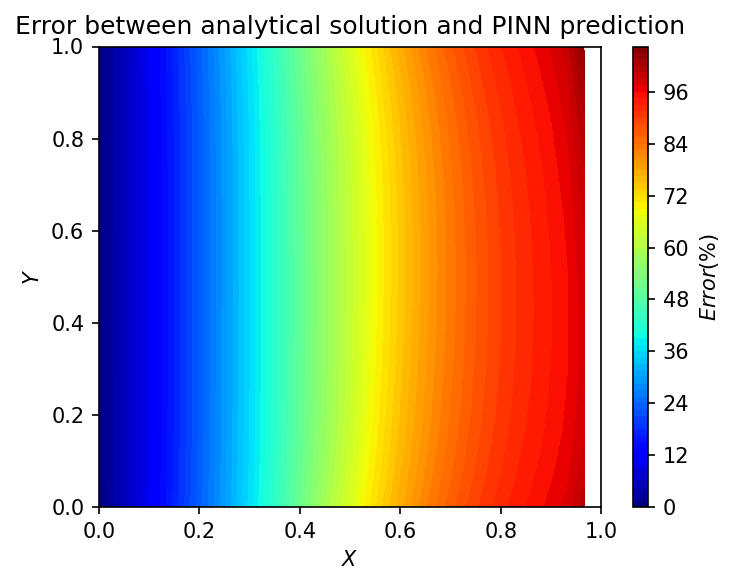

In [65]:
# Plot the percentage error
error_percentage = 100 * (analytical_h - pinn_h) / (analytical_h)
title = "Error between analytical solution and PINN prediction"
cbar_lebel = "$Error (\%)$"
plot_2d_pressure_distribution(X, Y, error_percentage, title, cbar_lebel)